In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import importlib
importlib.reload(powerplots)
from scroutines.miscu import is_in_polygon

/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)

In [3]:
# functions (the teacher wrote for you to use later)
def rot2d(x, y, theta, unit='degree'):
    """ rotate data points defined by `x` and `y` by `theta` degree
    """
    a = np.vstack([x,y]).T
    if unit == 'degree':
        theta = theta*np.pi/180 # convert to radian

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ar = a.dot(R.T)
    return ar[:,0], ar[:,1]

def st_scatter(x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    fig, ax = plt.subplots(figsize=(10,8))
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    if output:
        powerplots.savefig_autodate(fig, output)
        
    return 

# visualize clusters
def plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=True):
    """this assumes `clsts` is a integer that starts from 0
    """
    from matplotlib import colors
  
    unq_clsts, inv = np.unique(clsts, return_inverse=True)
    n_unq = len(unq_clsts)
    # colors = np.array(sns.color_palette('husl', n_unq))
    # c_vec = colors[inv]
  
    cmap = plt.cm.jet
    norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    
    ax = axs[0]
    g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('XY (spatial distribution)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    ax = axs[1]
    ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('UMAP (molecular similarity)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
  
    fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
    return fig, axs

In [4]:
outdir = "/data/qlyu/v1/results_merfish/plots_230623"
outdatadir = "/data/qlyu/v1/results_merfish"
!mkdir -p $outdir

In [5]:
adata = ad.read('/data/qlyu/v1/results_merfish/ant_reg0_ctxglut_230623.h5ad')
adata

AnnData object with n_obs × n_vars = 11615 × 500
    obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'leiden_r0.1', 'leiden_spatial_r0.02', 'leiden_r0.2', 'leiden_r0.5'
    uns: 'leiden', 'neighbors'
    obsm: 'blanks', 'pca', 'umap', 'xy'
    layers: 'norm'
    obsp: 'connectivities', 'distances'

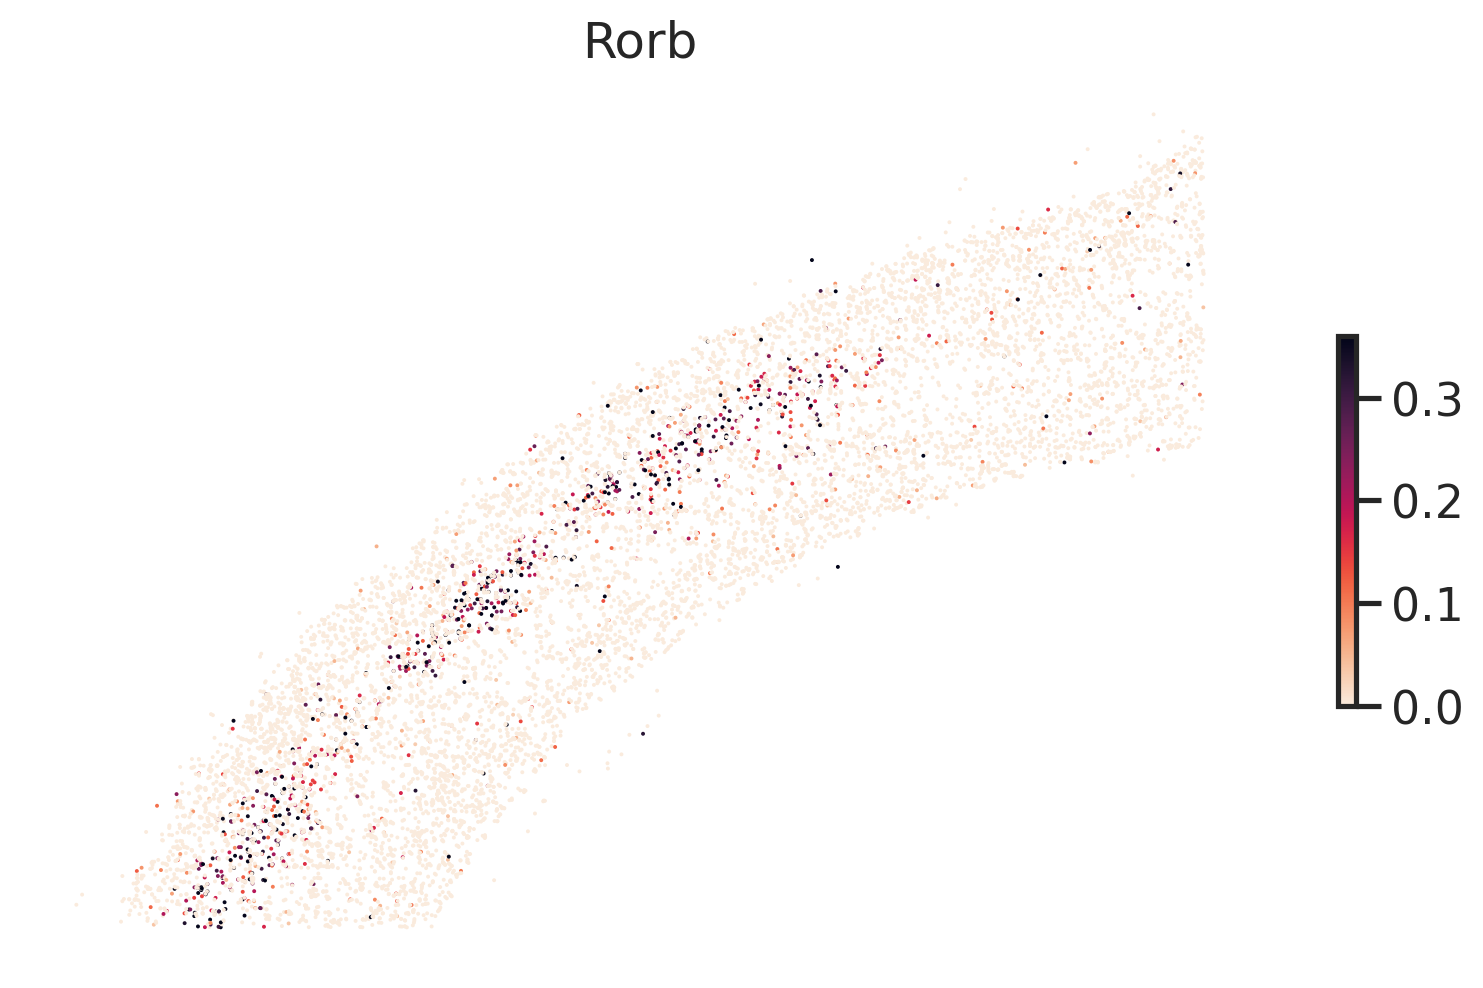

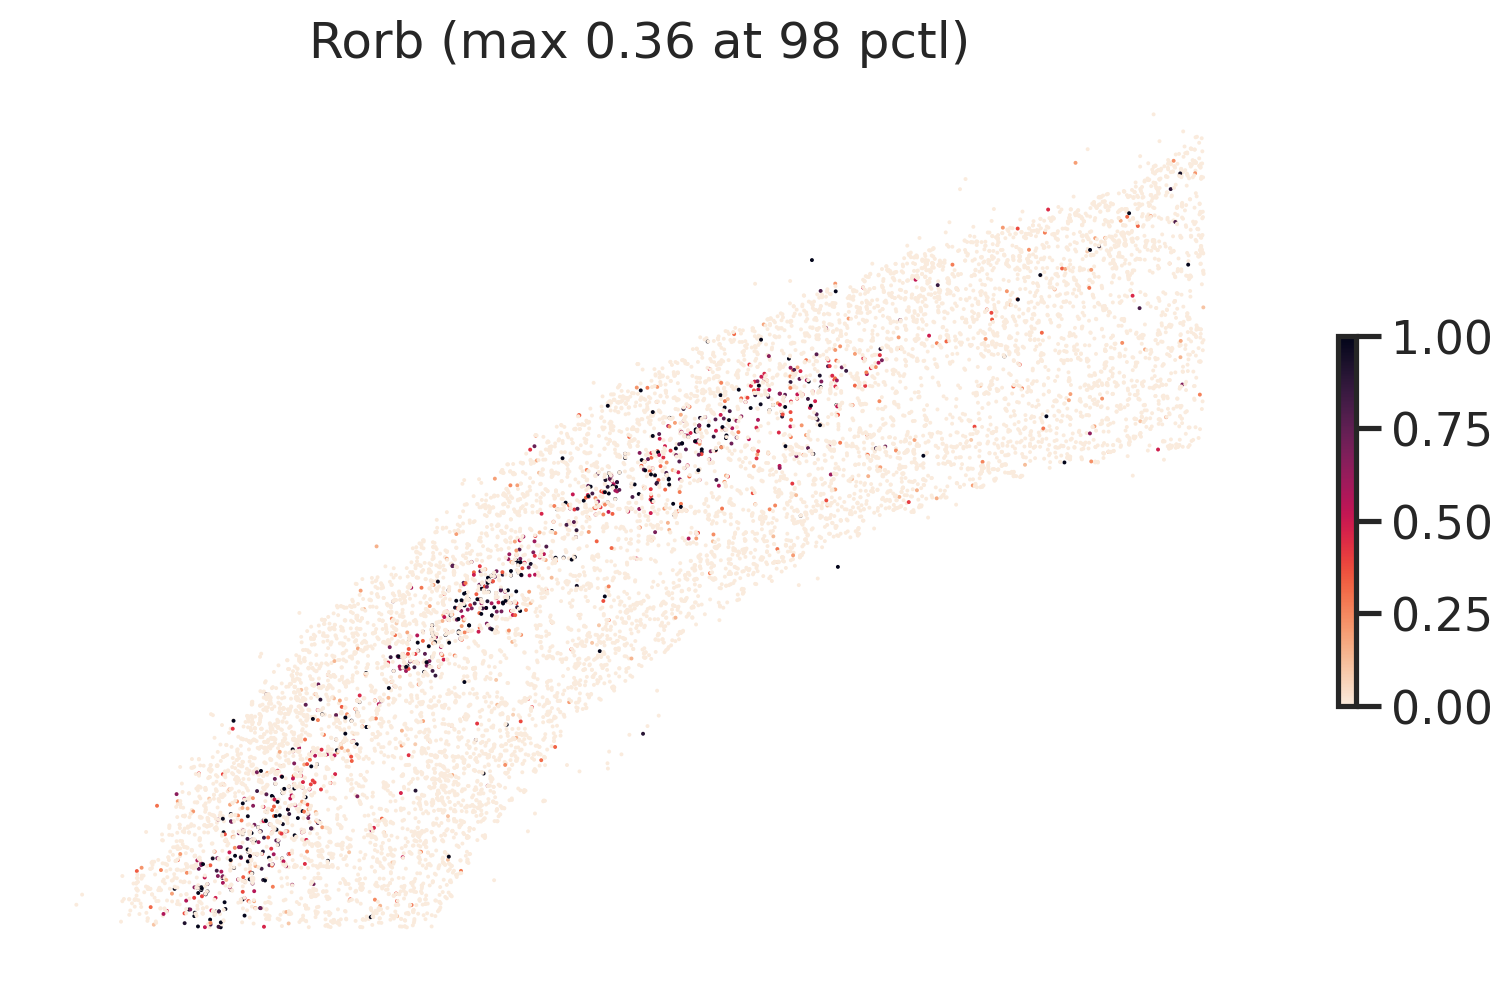

In [6]:
gn = 'Rorb'

x = adata.obs['x']
y = adata.obs['y']
ux = adata.obsm['umap'][:,0]
uy = adata.obsm['umap'][:,1]

g = np.log10(1+adata[:,gn].layers['norm'])

st_scatter(x, y, gexp=g, s=2, title=gn)
st_scatter(x, y, gexp=g, s=2, title=gn, unit_norm=True)
# st_scatter(ux, uy, gexp=g, s=2, title=gn)

# cortical areas
- where are visual ctx? where are V1?


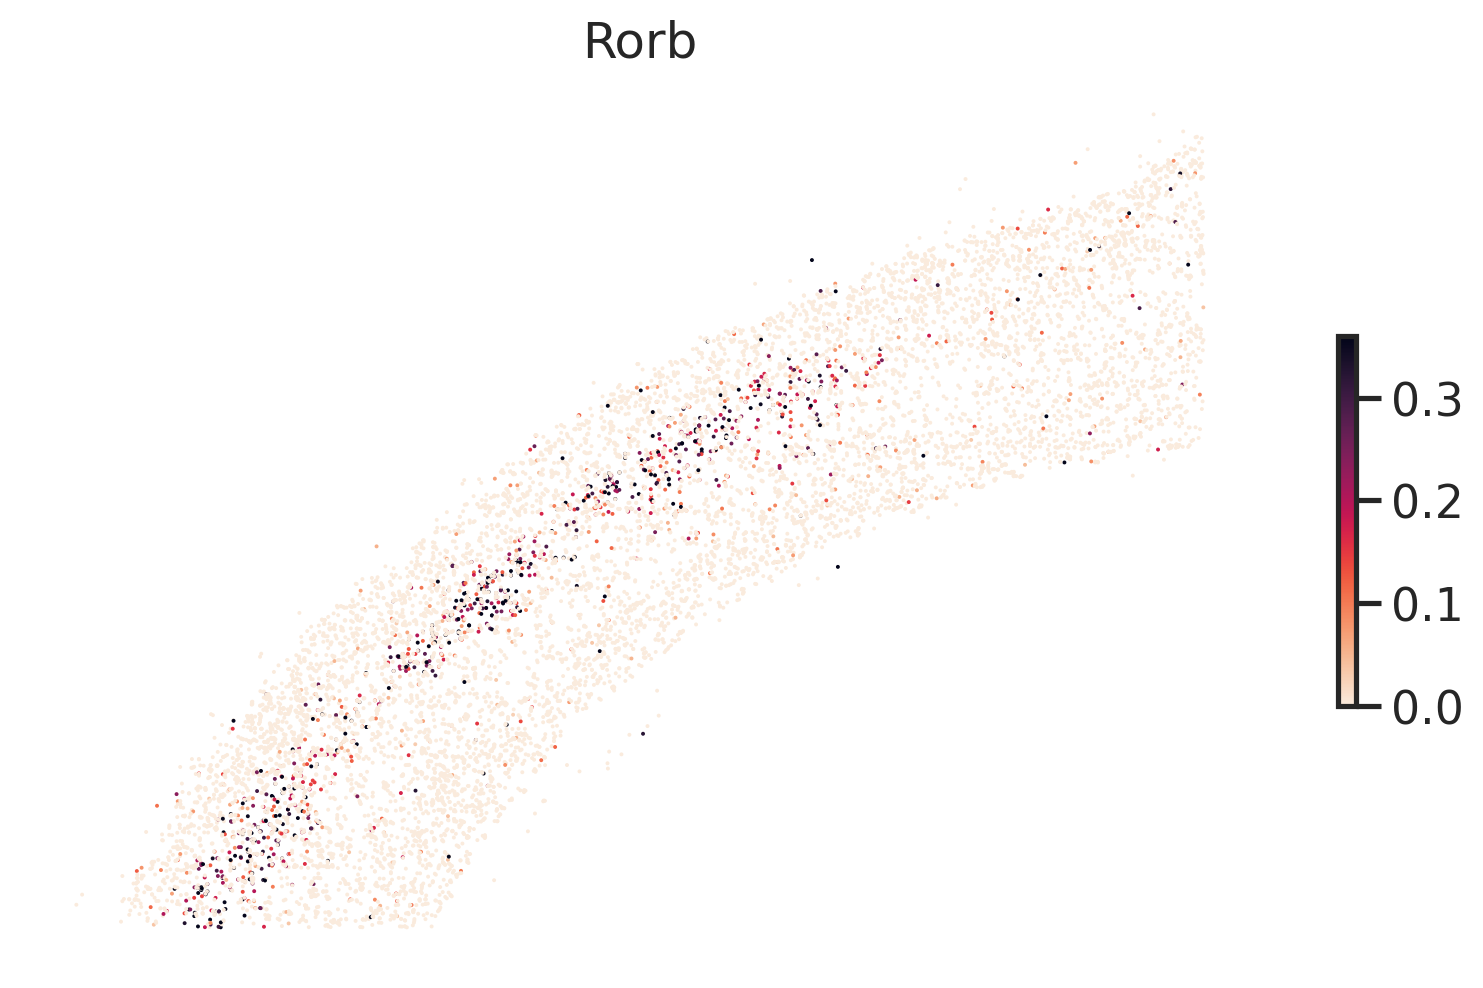

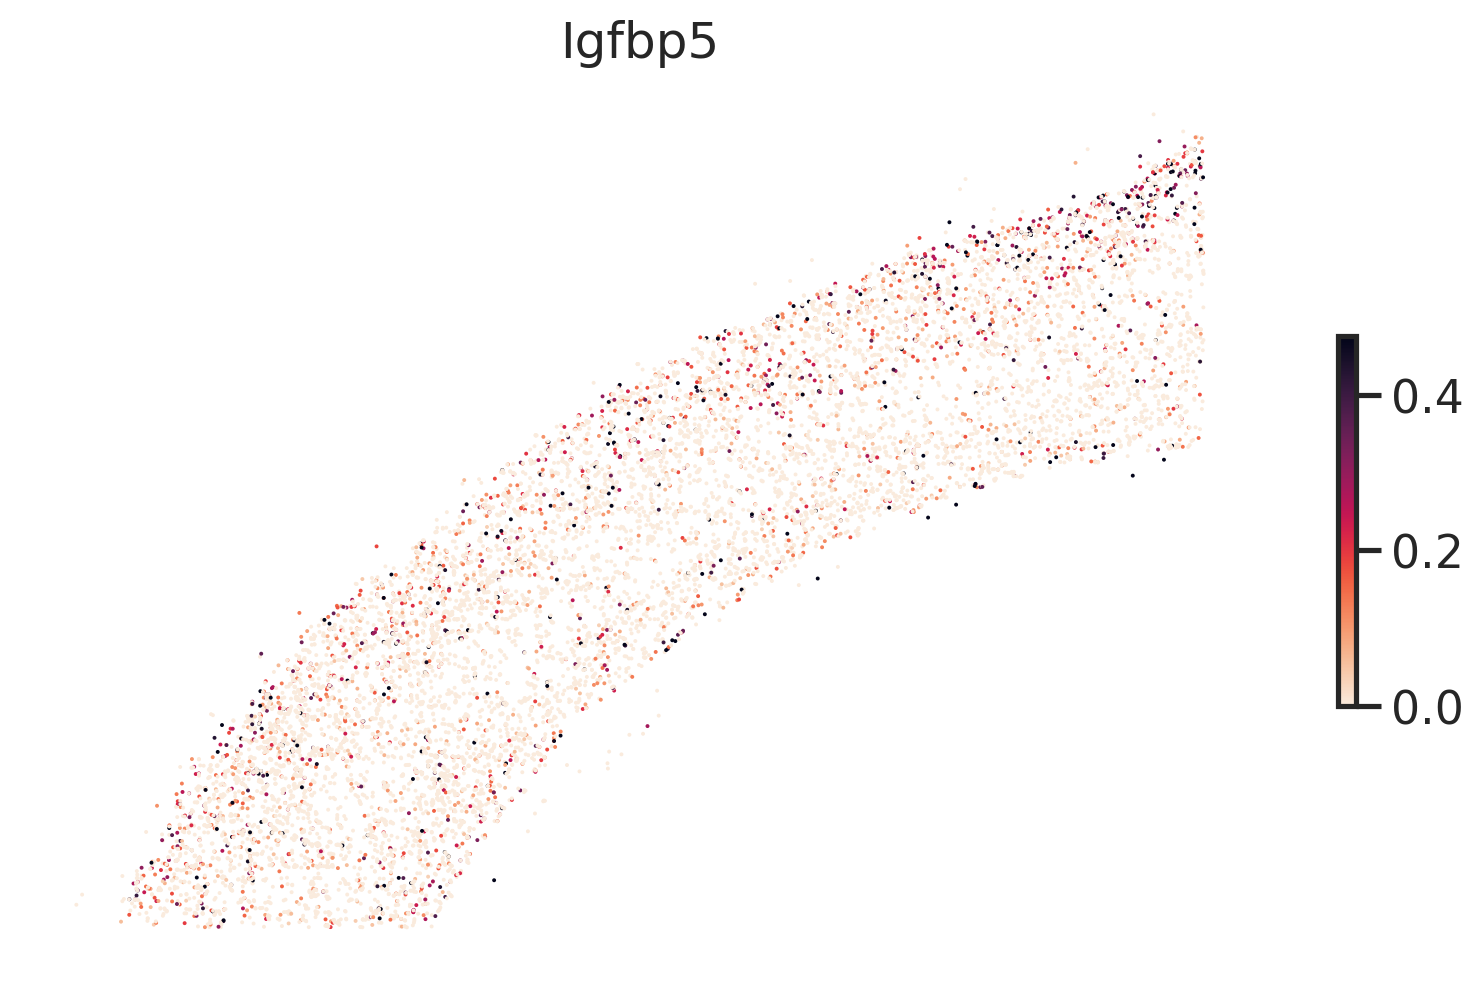

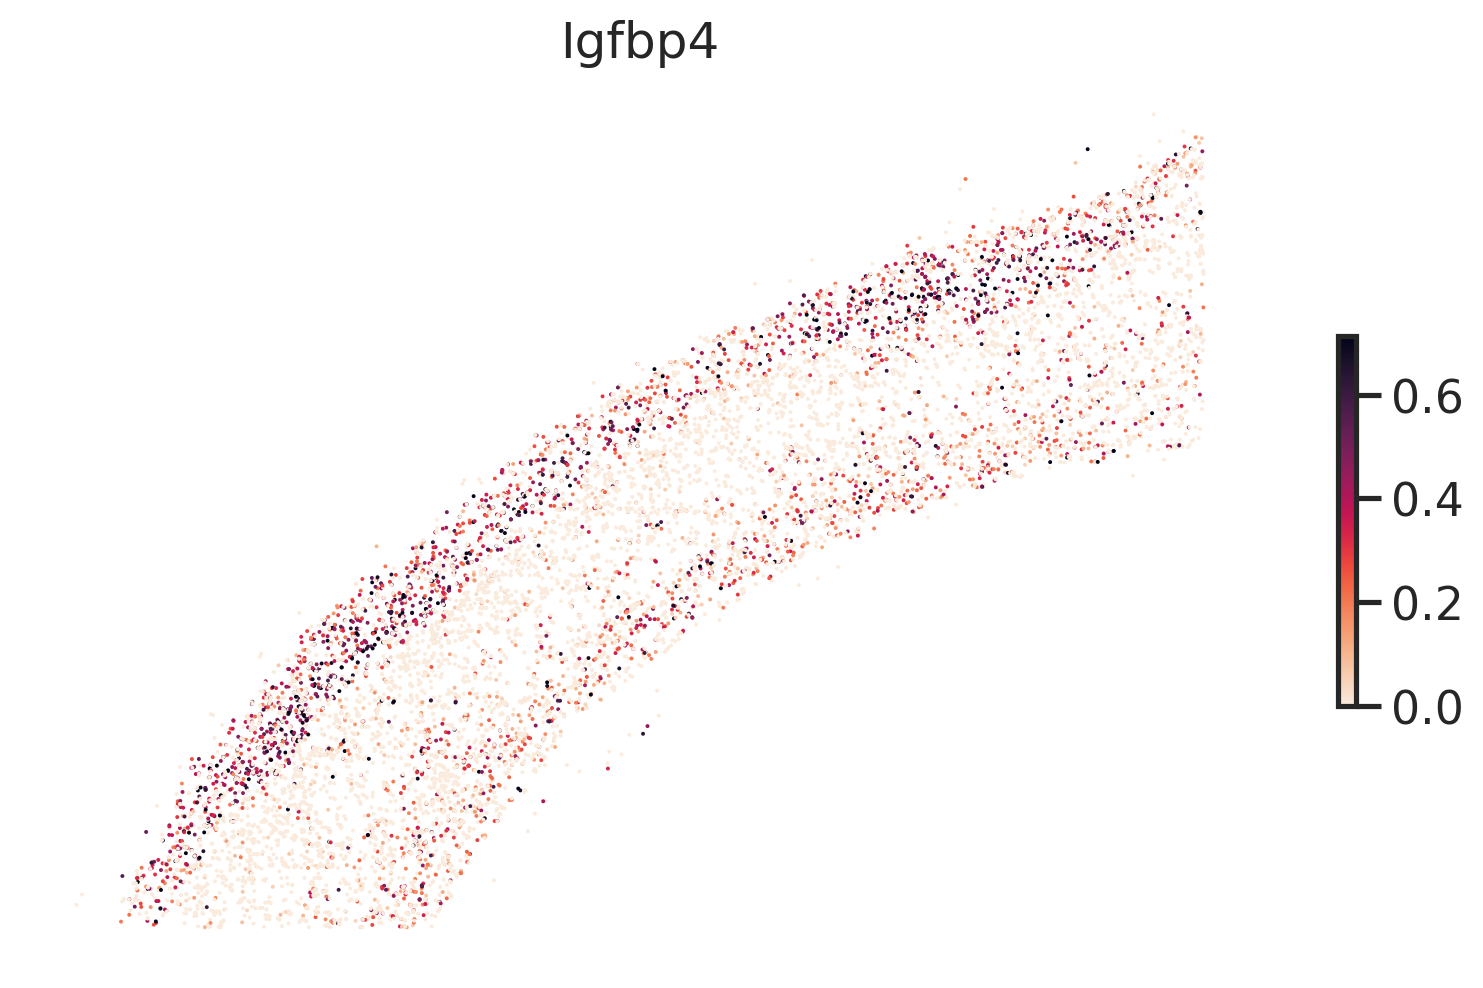

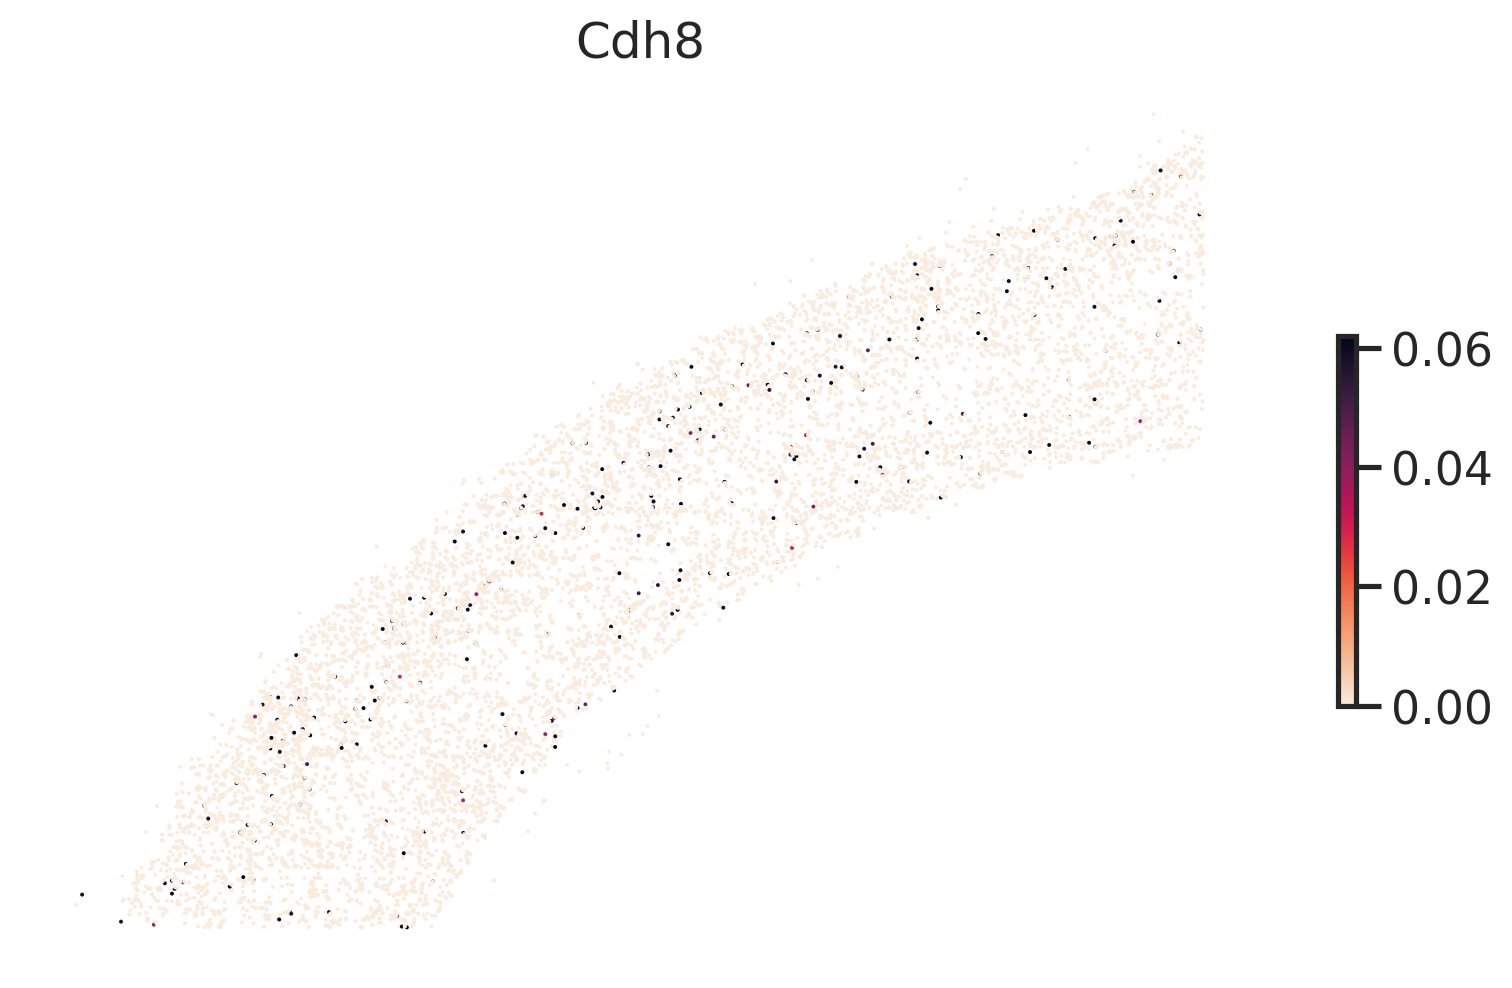

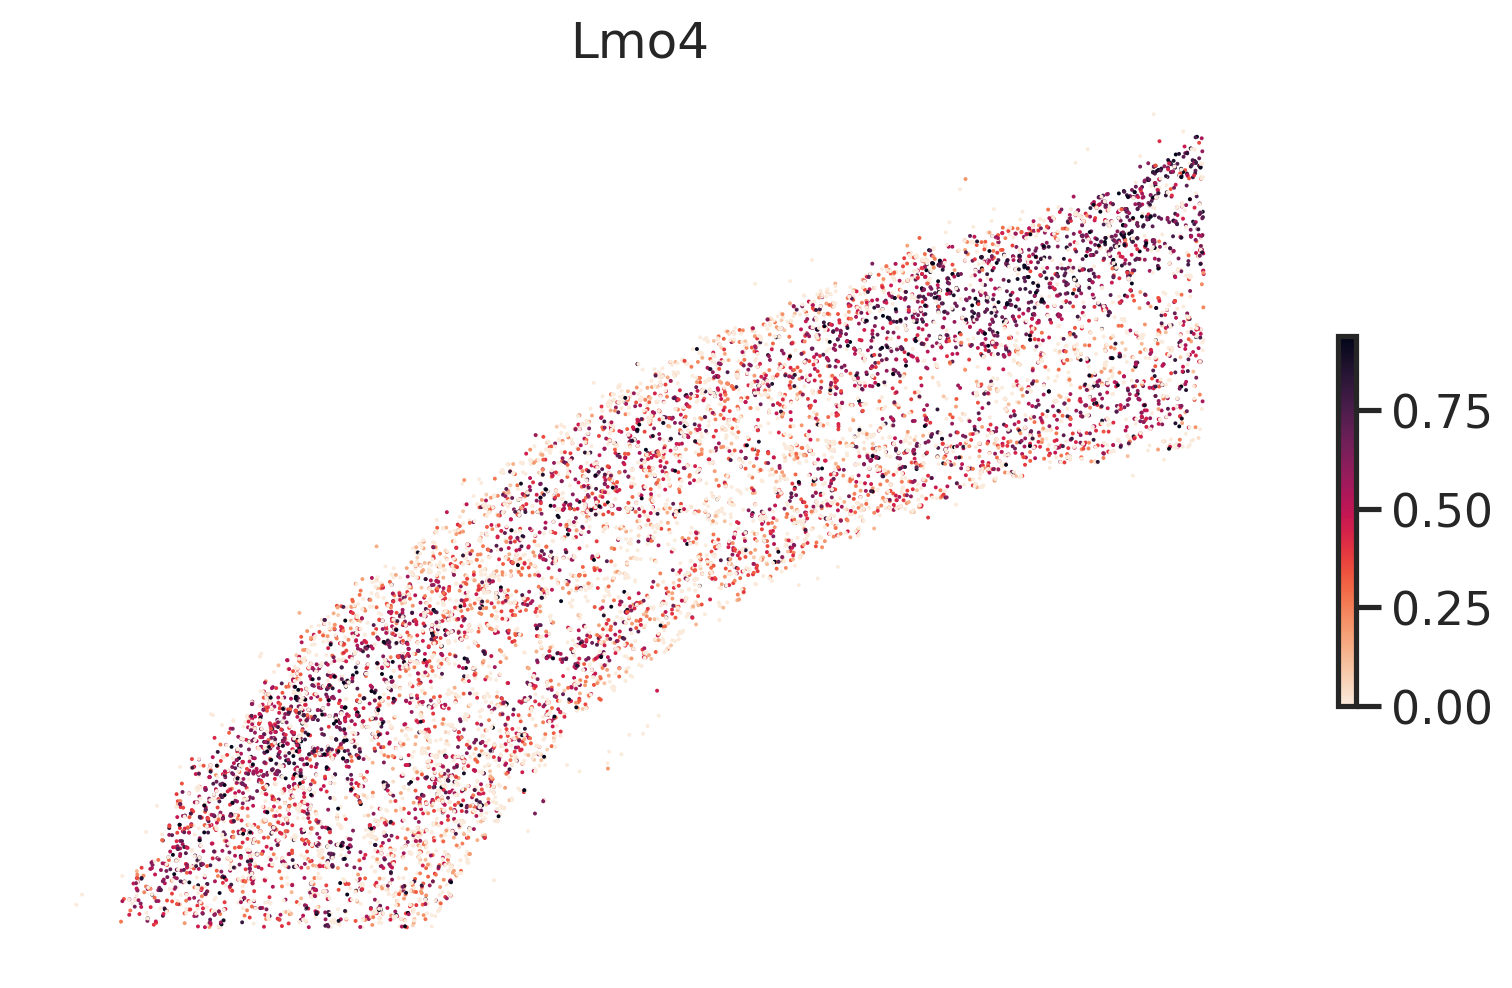

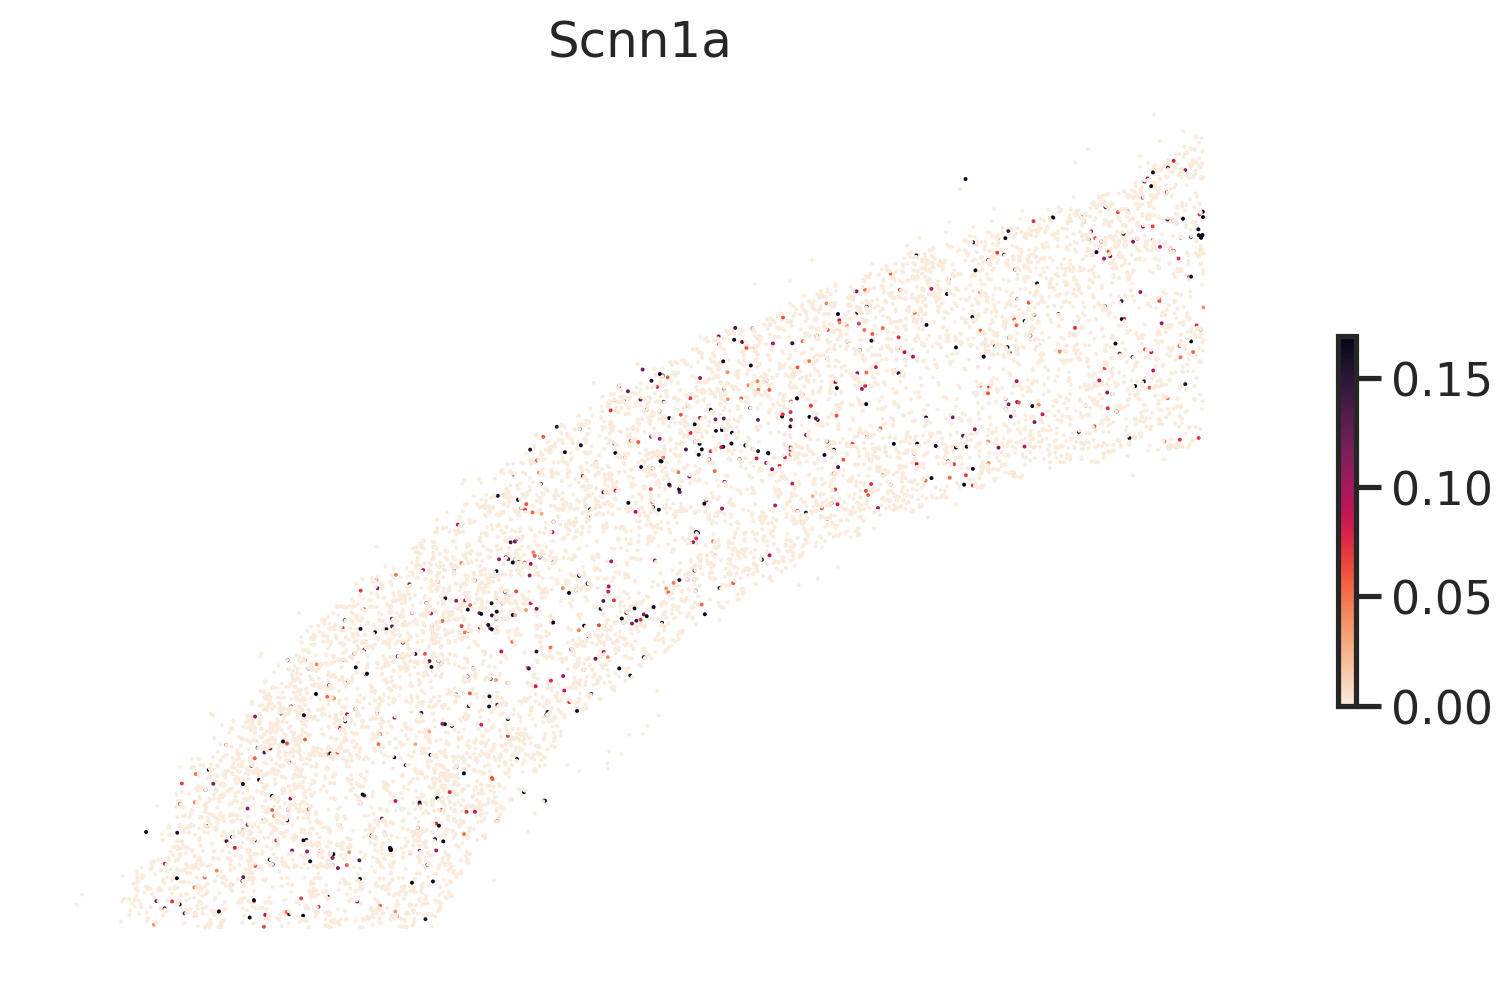

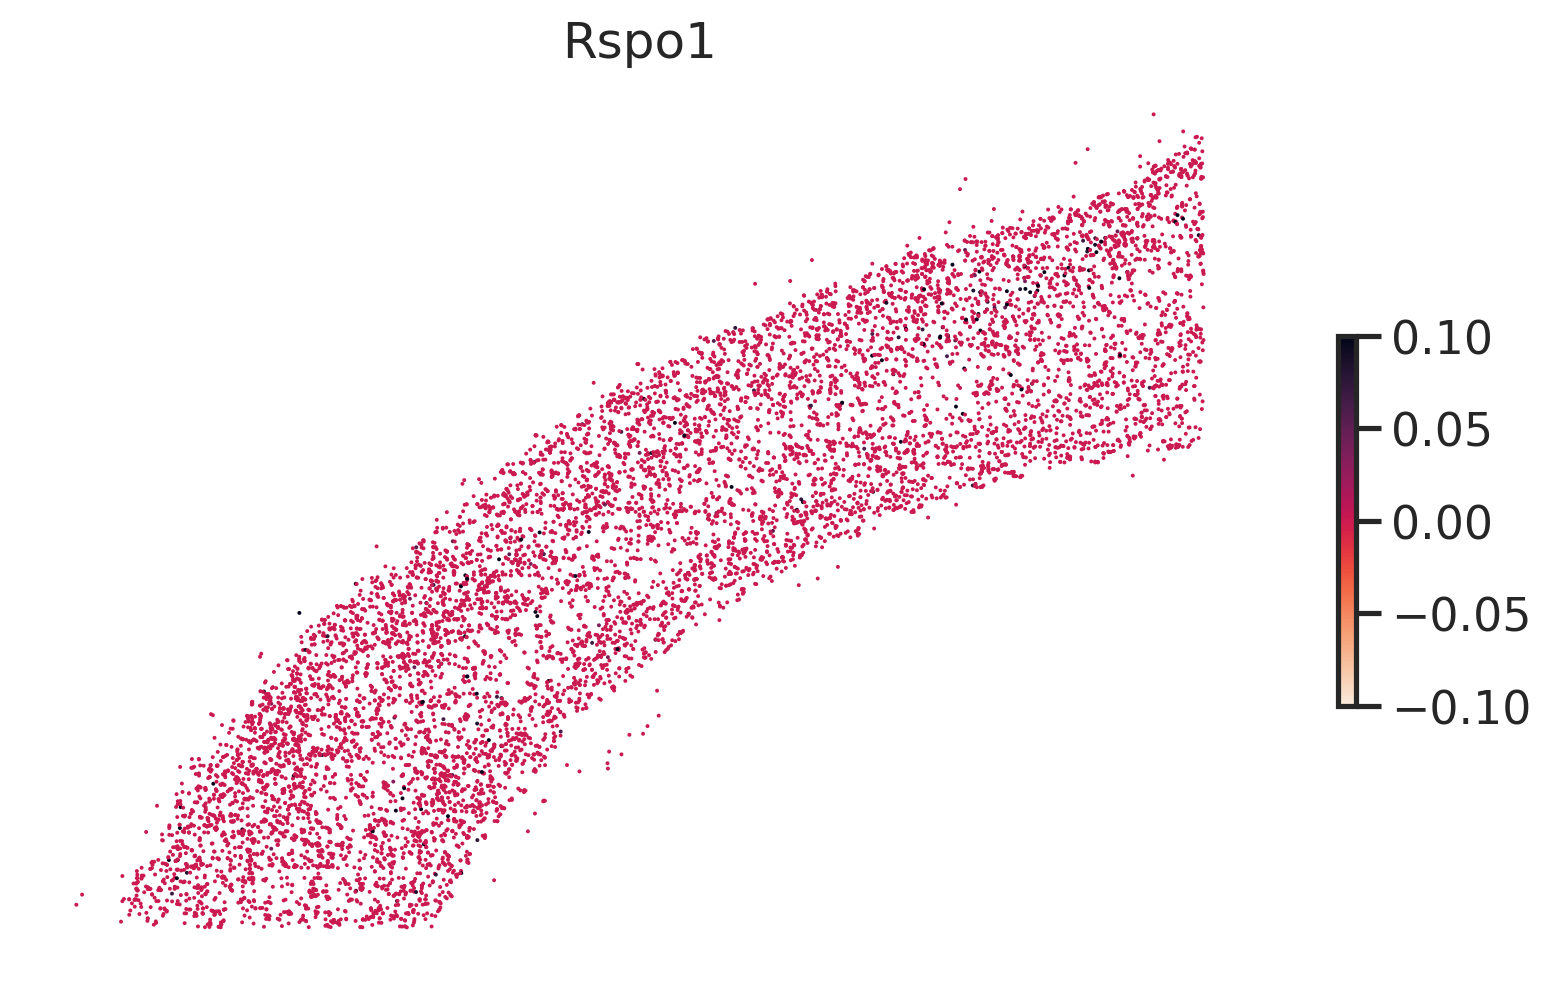

In [7]:
gns = [
    # chou 13
    'Rorb', # +
    'Igfbp5', # +
    'Igfbp4', # -
    'Cdh8', # -
    'Lmo4', # -
    
    # # Vue 13
    # 'Id2', # -
    
    # Vincent - L4
    'Scnn1a', 
    'Rspo1',
]

for gn in gns:
    g = np.log10(1+adata[:,gn].layers['norm'])
    st_scatter(x, y, gexp=g, s=2, title=gn)
    plt.show()
    # plt.close()
    # st_scatter(ux, uy, gexp=g, s=2, title=gn)

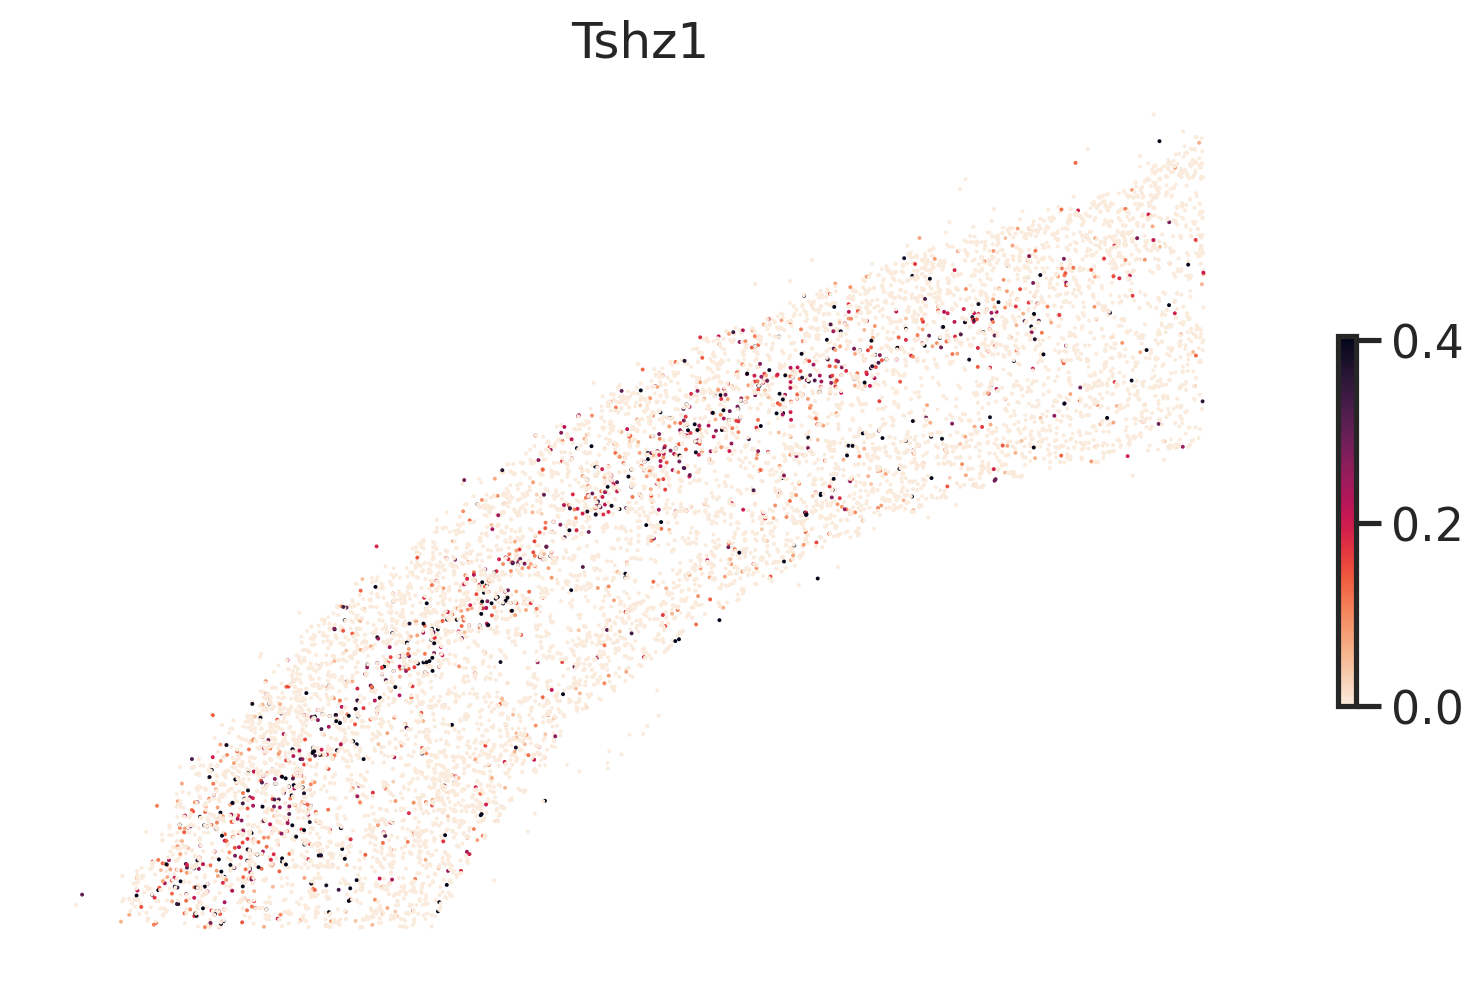

In [8]:
gns = [
    # 'Astn2',
    # 'Ntn4',
    # 'Nefm',
    # 'Cadps2',
    # 'Hunk',
    # 'Shisa6',
    # 'Syt10',
    # 'Syt17',
    # 'Plxnd1',
    # 'Meis2',
    # 'Epha6',
    # 'Cdh4',
    # 'Ldb2',
    # 'Col26a1',
    # 'Nell1',
    # 'Sorcs3',
    # 'Brinp3',
    # 'Mkx',
    'Tshz1',
]

for gn in gns:
    g = np.log10(1+adata[:,gn].layers['norm'])
    st_scatter(x, y, gexp=g, s=2, title=gn)
    plt.show()
    # plt.close()
    # st_scatter(ux, uy, gexp=g, s=2, title=gn)

# all ABC genes in order

In [9]:
f = '/data/qlyu/v1/results/MERFISH_gene_panel_Version1_March9.csv'
df = pd.read_csv(f)
f = '/data/qlyu/v1/results/gene_ptime_P28_L23_Mar27.tsv'
df2 = pd.read_csv(f).sort_values('gene_ptime')
df = pd.merge(df, df2, left_on='gene_name_data', right_on='gene').sort_values('gene_ptime')
genes_abco = df['gene_name_vizgen'].values
genes_abco.shape

(170,)

# Merge A,B,C

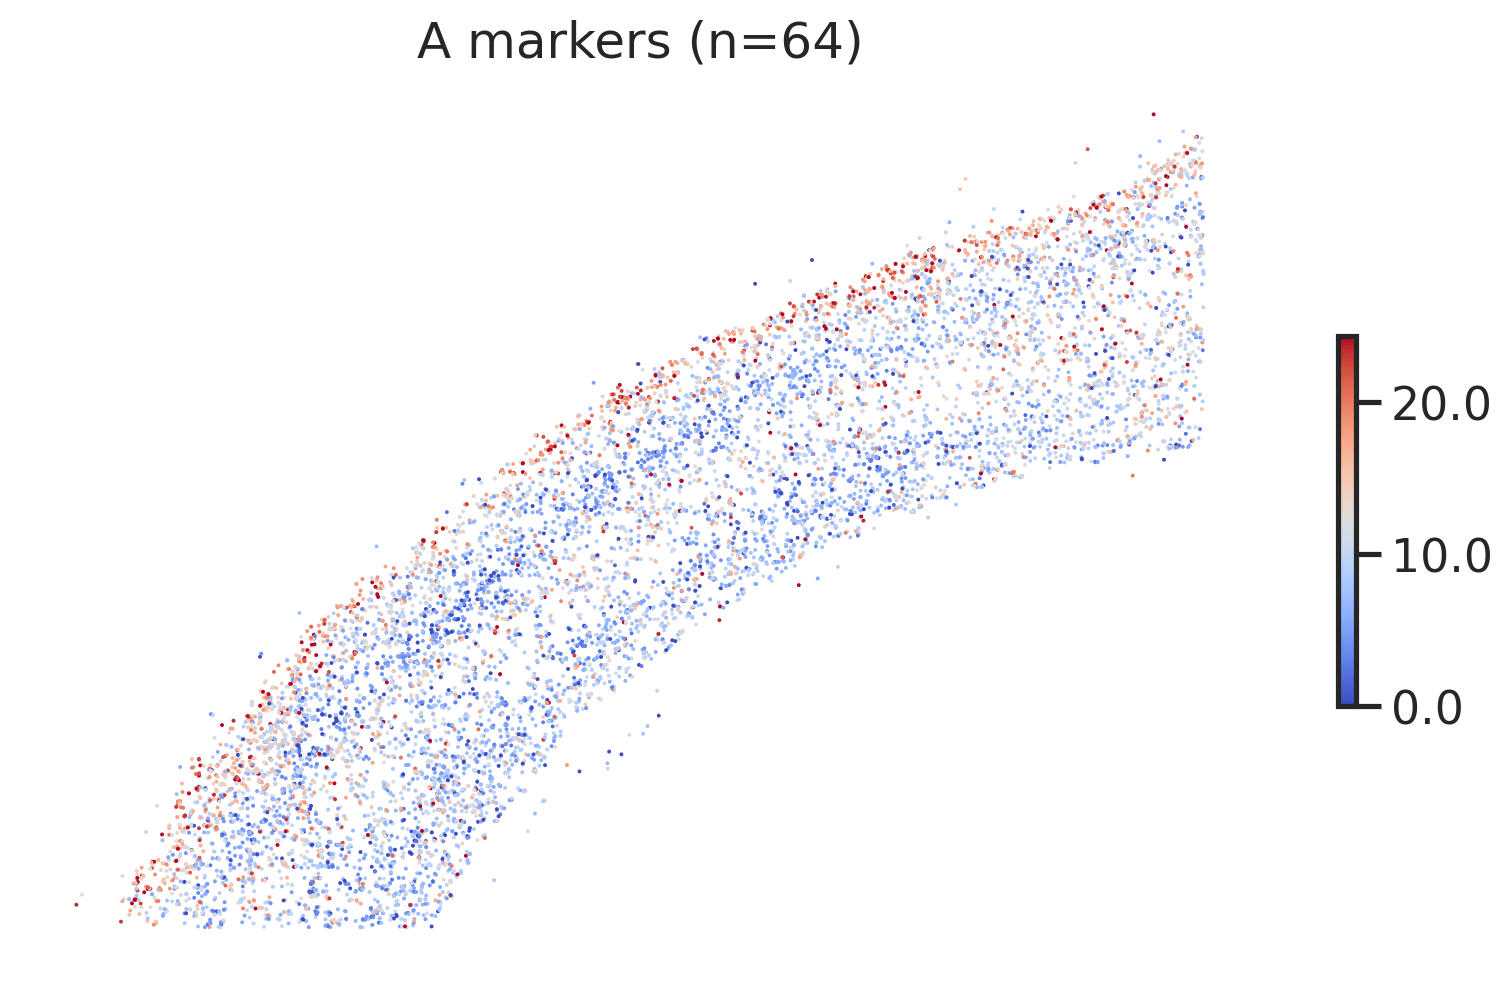

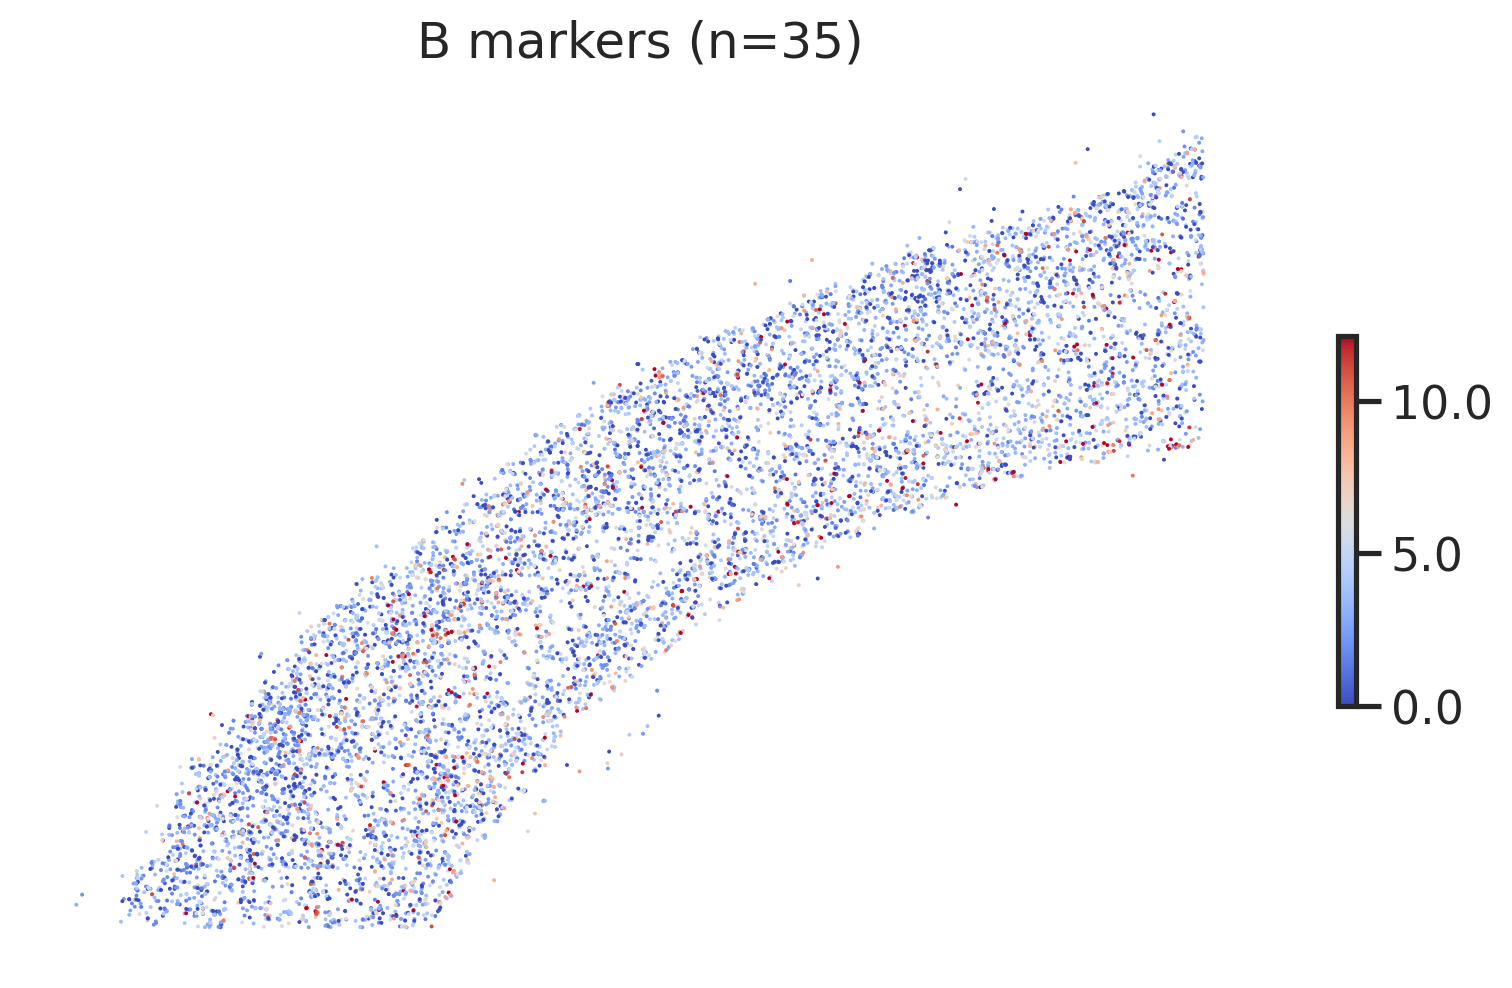

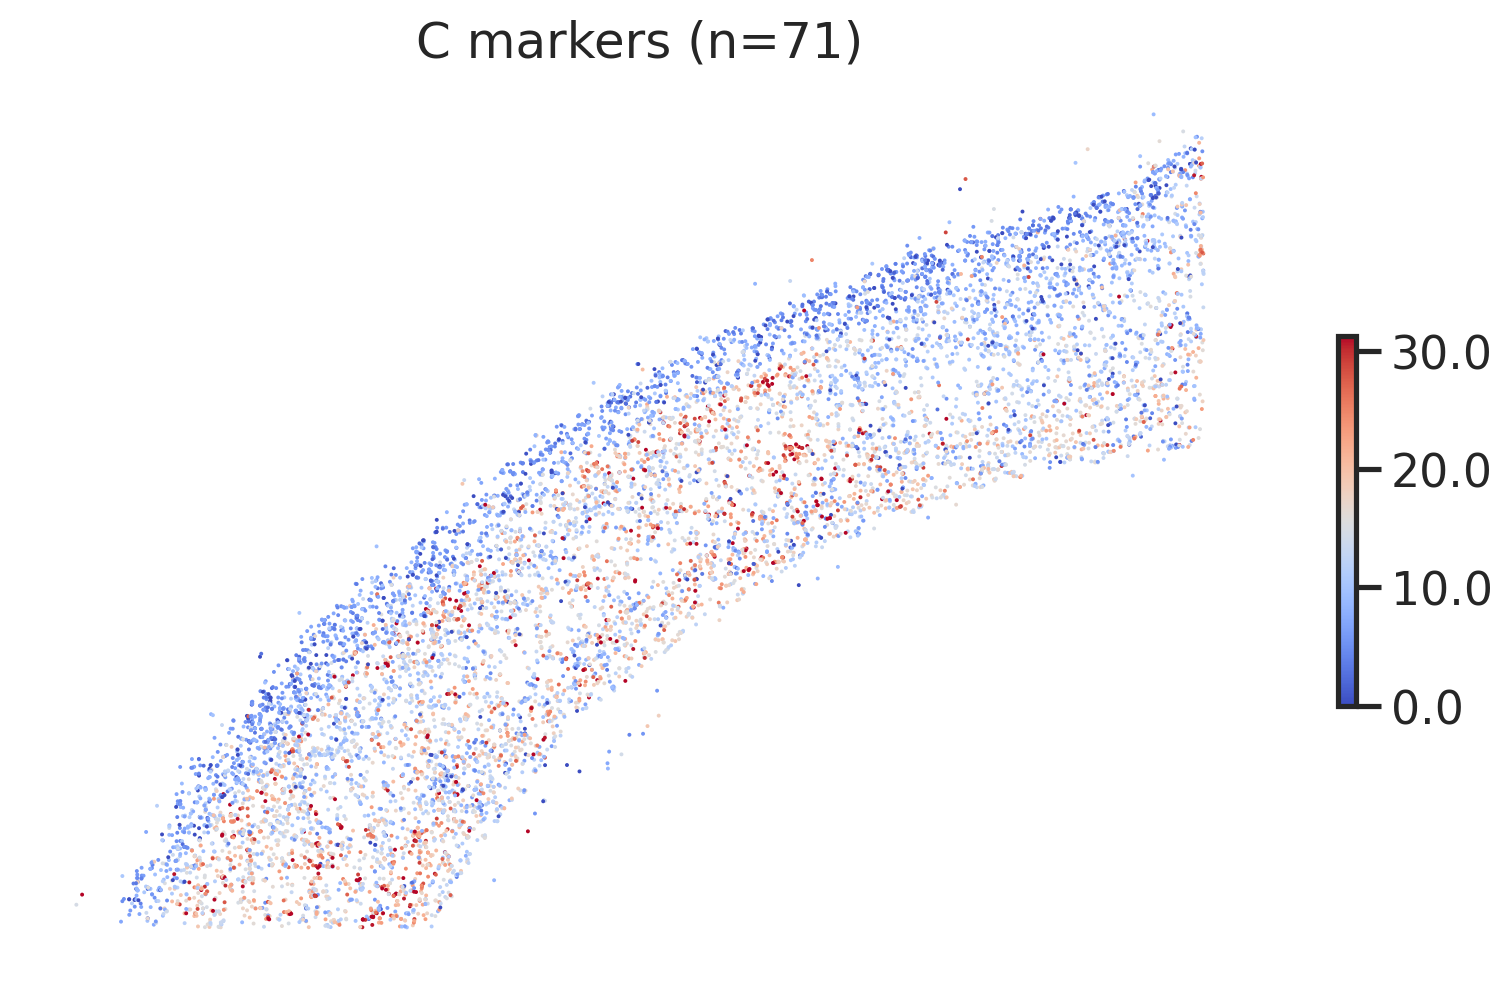

In [10]:
adata_a = adata[:,df[df['P17on_x']=='A']['gene_name_vizgen']]
g = np.sum(adata_a.layers['norm'], axis=1)
st_scatter(x, y, gexp=g, s=2, title=f'A markers (n={adata_a.shape[1]})', cmap='coolwarm', format='{x:.1f}')

adata_b = adata[:,df[df['P17on_x']=='B']['gene_name_vizgen']]
g = np.sum(adata_b.layers['norm'], axis=1)
st_scatter(x, y, gexp=g, s=2, title=f'B markers (n={adata_b.shape[1]})', cmap='coolwarm', format='{x:.1f}')

adata_c = adata[:,df[df['P17on_x']=='C']['gene_name_vizgen']]
g = np.sum(adata_c.layers['norm'], axis=1)
st_scatter(x, y, gexp=g, s=2, title=f'C markers (n={adata_c.shape[1]})', cmap='coolwarm', format='{x:.1f}')

In [11]:
from scipy.stats import zscore

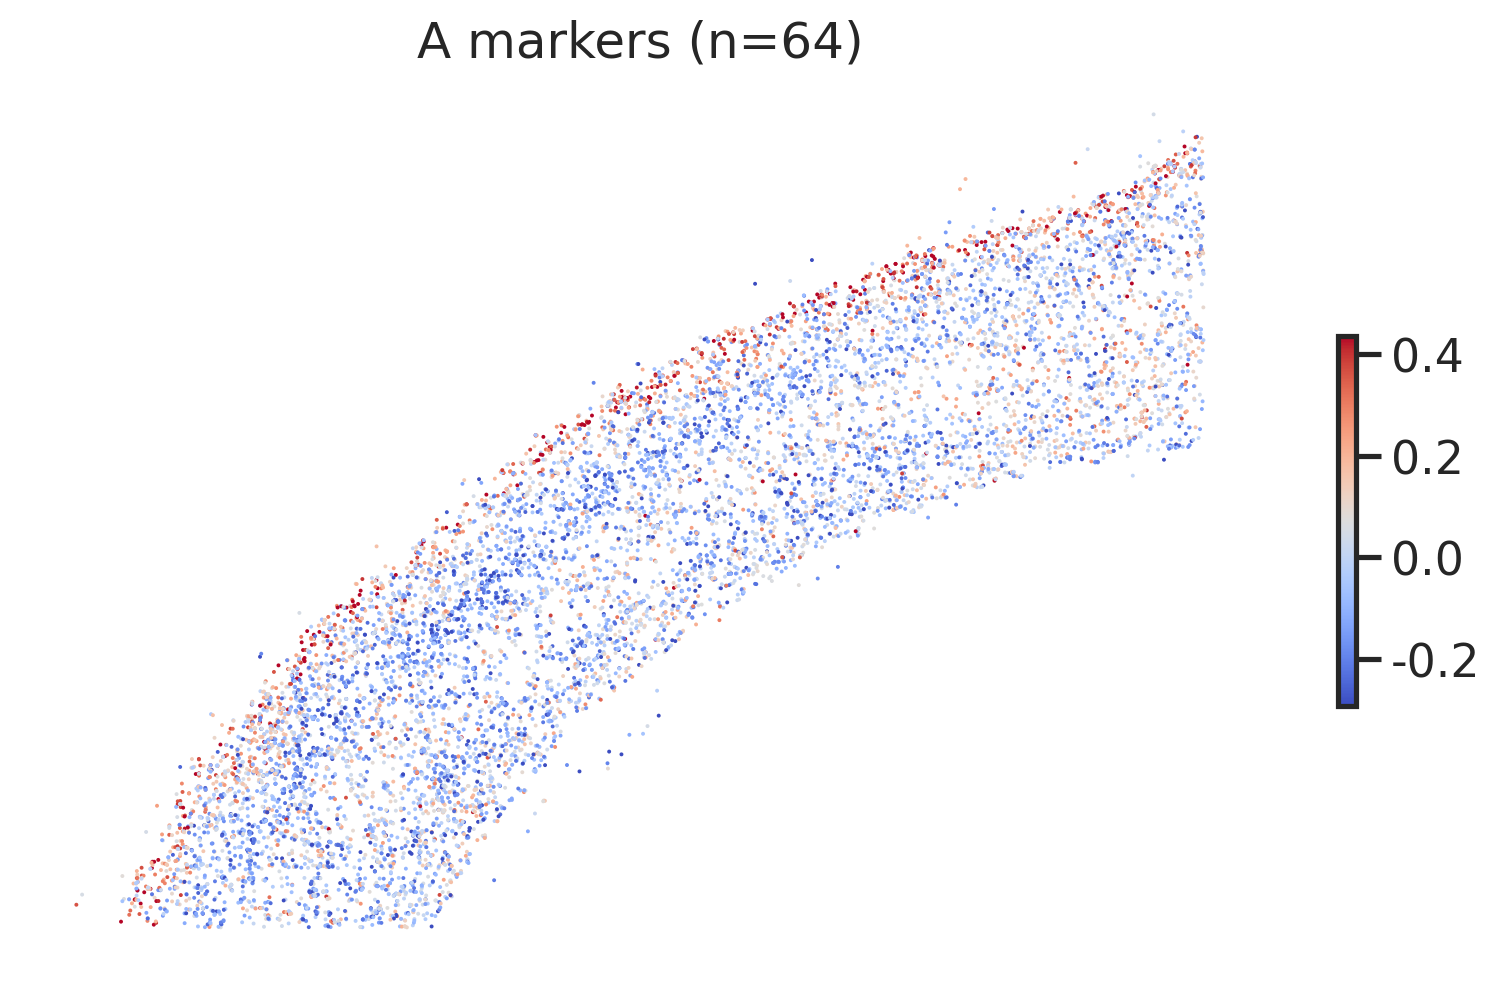

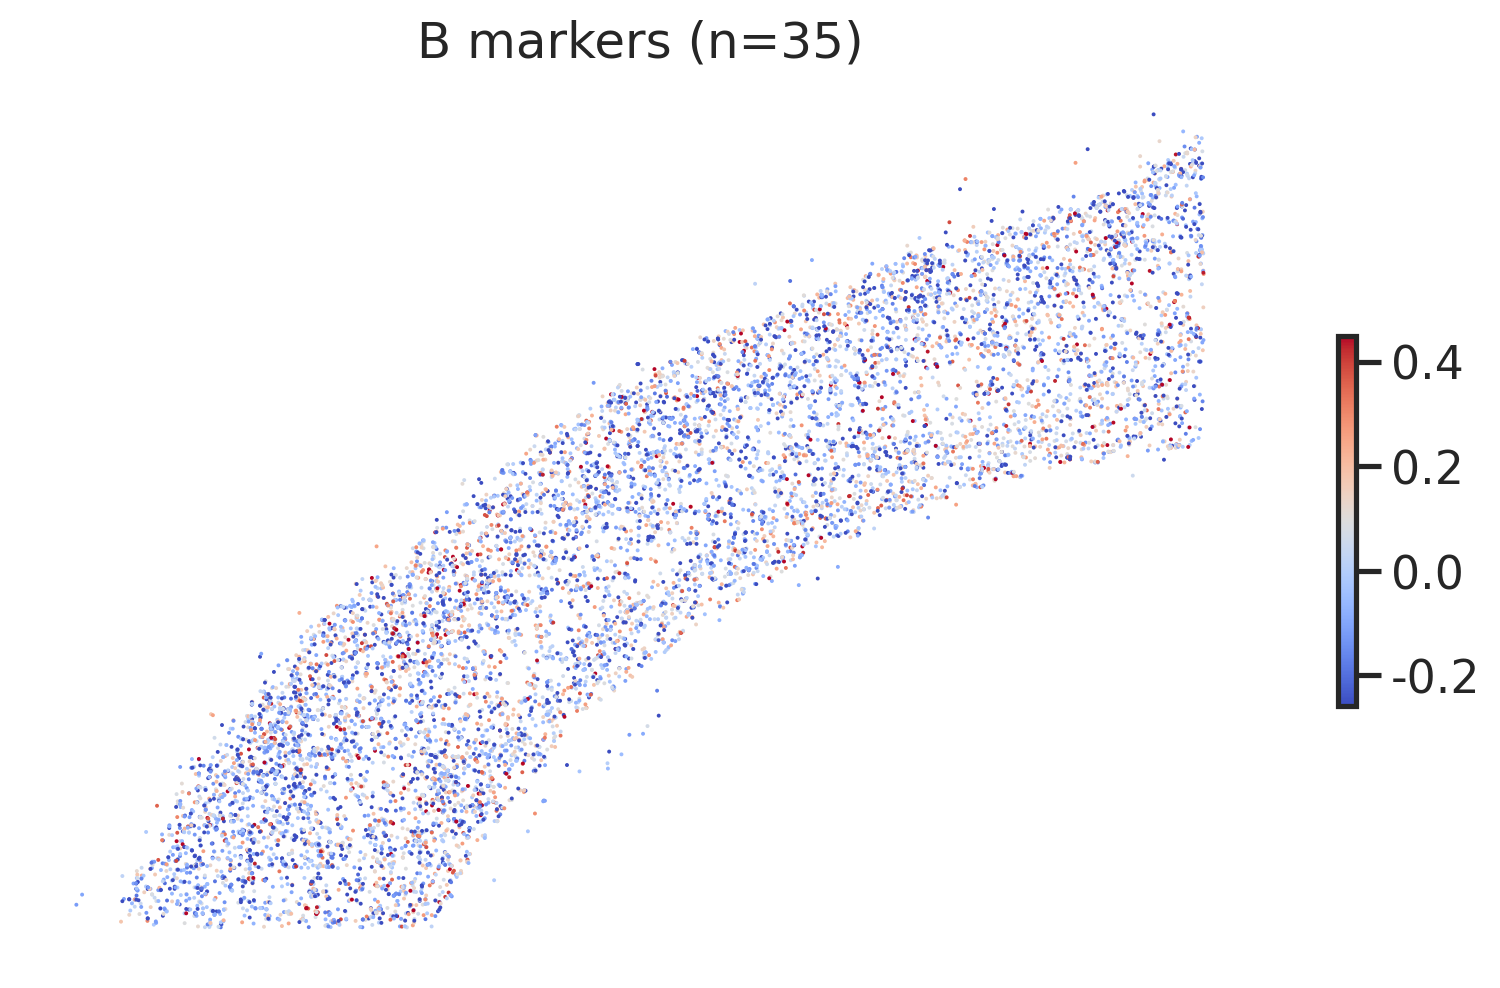

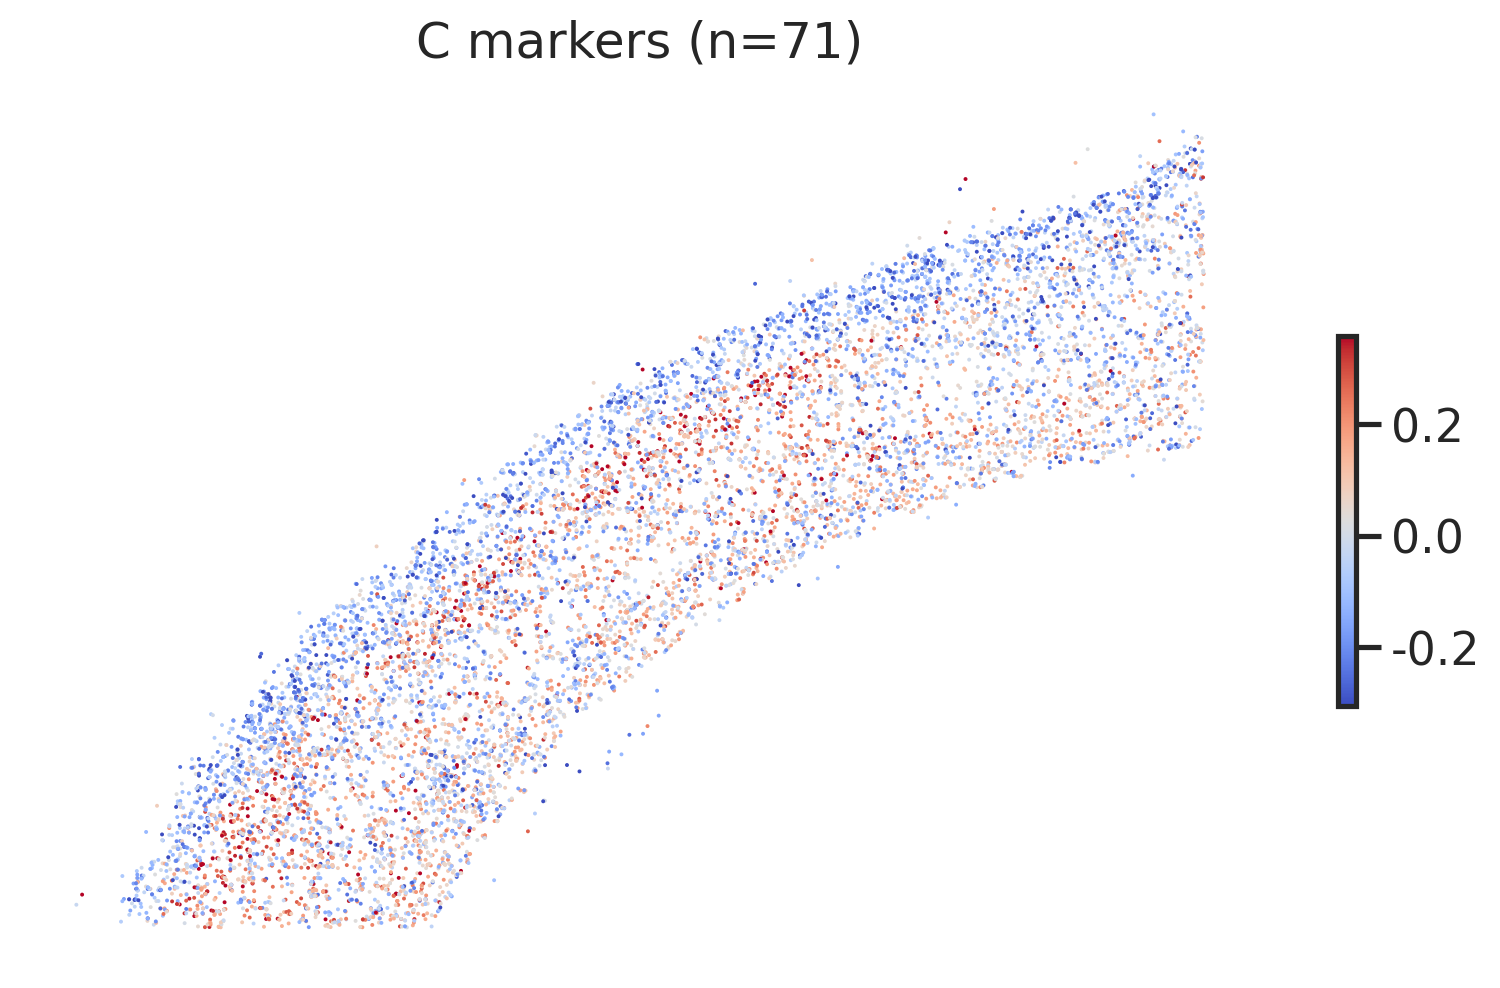

In [12]:
for cat in ['A', 'B', 'C']:
    adata_ = adata[:,df[df['P17on_x']==cat]['gene_name_vizgen']]
    g = np.mean(zscore(np.log10(1+np.array(adata_.layers['norm'])), axis=0), axis=1)
    st_scatter(x, y, gexp=g, s=2, title=f'{cat} markers (n={adata_.shape[1]})', cmap='coolwarm', format='{x:.1f}')

In [13]:
!rm $outdir/*

In [14]:
for i, gn in enumerate(genes_abco):
    g = np.log10(1+adata[:,gn].layers['norm'])
    title = f'{i:03d}_{gn}'
    output = outdir+f"/{title}.pdf"
    print(output)
    st_scatter(x, y, gexp=g, s=2, title=title, format='{x:.2f}', vmin=0, unit_norm=True, output=output)
    # plt.show()
    plt.close()
    # st_scatter(ux, uy, gexp=g, s=2, title=gn)
    # break

/data/qlyu/v1/results_merfish/plots_230623/000_Met.pdf
saved the figure to: /data/qlyu/v1/results_merfish/plots_230623/000_Met_2023-06-26.pdf
/data/qlyu/v1/results_merfish/plots_230623/001_6530403H02Rik.pdf


/tmp/ipykernel_2358809/1309222712.py:24: RuntimeWarning: divide by zero encountered in divide
  rgexp = gexp/vmax
/tmp/ipykernel_2358809/1309222712.py:24: RuntimeWarning: invalid value encountered in divide
  rgexp = gexp/vmax


saved the figure to: /data/qlyu/v1/results_merfish/plots_230623/001_6530403H02Rik_2023-06-26.pdf
/data/qlyu/v1/results_merfish/plots_230623/002_Rhbdl3.pdf
saved the figure to: /data/qlyu/v1/results_merfish/plots_230623/002_Rhbdl3_2023-06-26.pdf
/data/qlyu/v1/results_merfish/plots_230623/003_Adamts2.pdf
saved the figure to: /data/qlyu/v1/results_merfish/plots_230623/003_Adamts2_2023-06-26.pdf
/data/qlyu/v1/results_merfish/plots_230623/004_Cdh13.pdf
saved the figure to: /data/qlyu/v1/results_merfish/plots_230623/004_Cdh13_2023-06-26.pdf
/data/qlyu/v1/results_merfish/plots_230623/005_Col23a1.pdf
saved the figure to: /data/qlyu/v1/results_merfish/plots_230623/005_Col23a1_2023-06-26.pdf
/data/qlyu/v1/results_merfish/plots_230623/006_Vwc2l.pdf
saved the figure to: /data/qlyu/v1/results_merfish/plots_230623/006_Vwc2l_2023-06-26.pdf
/data/qlyu/v1/results_merfish/plots_230623/007_Syt10.pdf
saved the figure to: /data/qlyu/v1/results_merfish/plots_230623/007_Syt10_2023-06-26.pdf
/data/qlyu/v1/res

# layer specificity 

In [15]:
# gns = [
#     'Cux2',
#     'Rorb',
#     'Whrn',
# ]

# for gn in gns:
#     g = np.log10(1+adatasub5[:,gn].layers['norm'])
#     st_scatter(x, y, gexp=g, s=2, title=gn)
#     plt.show()
#     # plt.close()
#     # st_scatter(ux, uy, gexp=g, s=2, title=gn)

In [16]:
# gns = [
#     'Cdh13',
#     'Adamts2',
#     'Nr4a3',
#     'Cntn5',
#     'Gabrg3',
#     'Grm8',
#     'Sorcs3',
#     'Chrm2',
#     'Cdh12',
#     'Cntnap2',
#     'Kcnh5',
#     'Kcnq5',
#     'Ncam2',
#     'Gria3',
#     'Rorb',
#     'Kcnip3',
#     'Baz1a',
#     'Rfx3',
#     'Trpc6',
#     'Egfem1',
#     'Igfn1',
#     'Bdnf',
#     'Epha3',
#     'Kcna1',
#     'Whrn',
#     'Igsf9b',
#     'Mdga1',
# ]

# for gn in gns:
#     g = np.log10(1+adatasub5[:,gn].layers['norm'])
#     st_scatter(x, y, gexp=g, s=2, title=gn)
#     plt.show()
#     # plt.close()
#     # st_scatter(ux, uy, gexp=g, s=2, title=gn)